In [9]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, average_precision_score

In [19]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    brier_score_loss
)

def calibrate_and_evaluate(model, model_name, method='sigmoid'):
    print(f"\n--- Calibrating and Evaluating: {model_name} ---")
    
    # 原始未校准的 test 预测概率
    probs_test_raw = model.predict_proba(X_test)[:, 1]

    # 用 val 集做校准
    calibrated = CalibratedClassifierCV(estimator=model, method=method, cv=5)
    calibrated.fit(X_val, y_val)

    # 校准后 test 预测概率
    probs_test_cal = calibrated.predict_proba(X_test)[:, 1]

    # ===== F1 vs Threshold（基于 test）
    precision, recall, thresholds = precision_recall_curve(y_test, probs_test_cal)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    print(f"Best threshold (test): {best_threshold:.4f}")

    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, f1_scores[:-1], 'b', label='F1-score')
    plt.axvline(best_threshold, linestyle='--', color='gray', label=f"Best threshold = {best_threshold:.2f}")
    plt.xlabel("Threshold")
    plt.ylabel("F1-score")
    plt.title("F1-score vs. Decision Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ===== Precision-Recall Curve（test）
    ap = average_precision_score(y_test, probs_test_cal)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f"{model_name} (AP={ap:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ===== 混淆矩阵（test）
    y_pred_test = (probs_test_cal >= best_threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_test)
    print(classification_report(y_test, y_pred_test, digits=3))
    ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.tight_layout()
    plt.show()

    # ===== 校准曲线 + 概率分布（test）
    fig, axs = plt.subplots(2, 1, figsize=(6, 8), gridspec_kw={'height_ratios': [2, 1]})
    prob_true_raw, prob_pred_raw = calibration_curve(y_test, probs_test_raw, n_bins=10)
    prob_true_cal, prob_pred_cal = calibration_curve(y_test, probs_test_cal, n_bins=10)

    axs[0].plot(prob_pred_raw, prob_true_raw, 'r-o', label="Original")
    axs[0].plot(prob_pred_cal, prob_true_cal, 'b-o', label="Calibrated")
    axs[0].plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
    axs[0].set_title(f"Reliability Curve: {model_name}")
    axs[0].set_ylabel("True Probability")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].hist([probs_test_raw, probs_test_cal], bins=20, label=["Original", "Calibrated"],
                color=["red", "blue"], alpha=0.6, edgecolor='black')
    axs[1].set_xlabel("Predicted Probability")
    axs[1].set_ylabel("Frequency")
    axs[1].set_title("Prediction Distribution")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

    # ===== ROC Curve（test）
    fpr_raw, tpr_raw, _ = roc_curve(y_test, probs_test_raw)
    fpr_cal, tpr_cal, _ = roc_curve(y_test, probs_test_cal)
    auc_raw = auc(fpr_raw, tpr_raw)
    auc_cal = auc(fpr_cal, tpr_cal)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr_raw, tpr_raw, 'r-', label=f'Original (AUC = {auc_raw:.2f})')
    plt.plot(fpr_cal, tpr_cal, 'b-', label=f'Calibrated (AUC = {auc_cal:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ===== Brier Score（test）
    brier_raw = brier_score_loss(y_test, probs_test_raw)
    brier_cal = brier_score_loss(y_test, probs_test_cal)
    print(f"Brier Score (original):   {brier_raw:.4f}")
    print(f"Brier Score (calibrated): {brier_cal:.4f}")


d:\02_Study\University\2025-02_COMP5703_Capstone_Project\2025-04_Github\CS25_CopperCoreAI_ML\geoenv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\02_Study\University\2025-02_COMP5703_Capstone_Project\2025-04_Github\CS25_CopperCoreAI_ML\geoenv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



--- Calibrating and Evaluating: Random Forest (All Features Transformed) ---
Best threshold (test): 0.5010


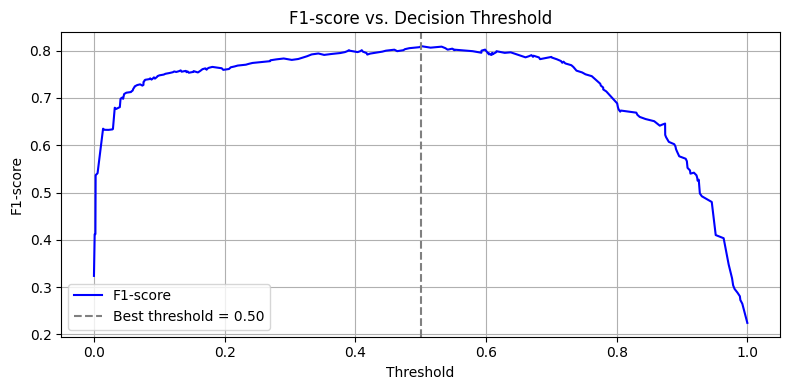

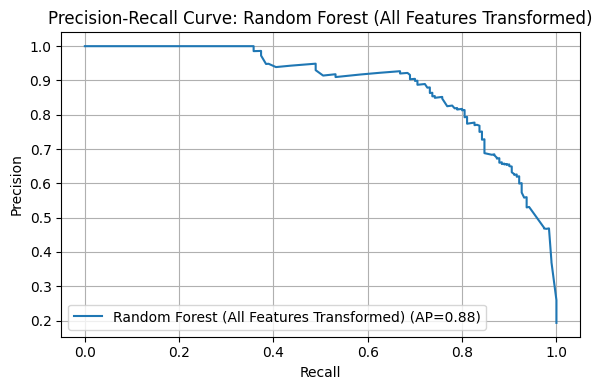

              precision    recall  f1-score   support

           0      0.954     0.956     0.955       794
           1      0.814     0.805     0.810       190

    accuracy                          0.927       984
   macro avg      0.884     0.881     0.882       984
weighted avg      0.927     0.927     0.927       984



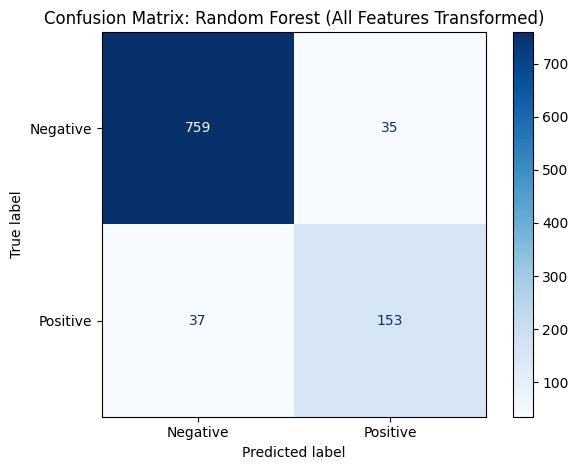

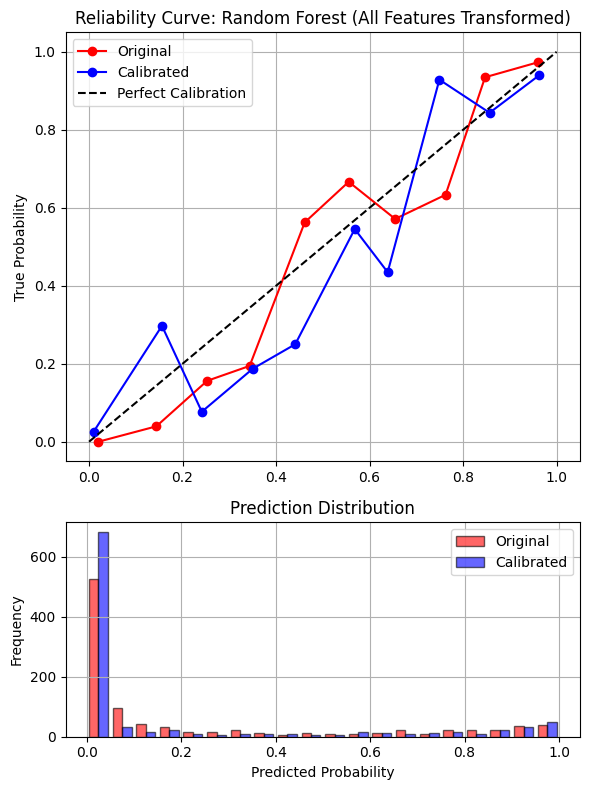

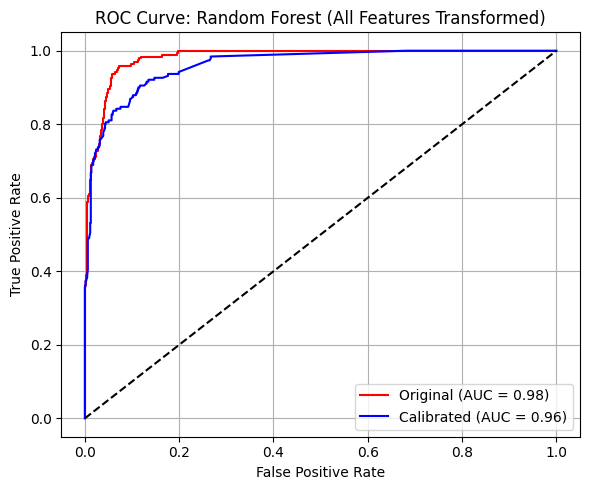

Brier Score (original):   0.0456
Brier Score (calibrated): 0.0571


In [ ]:
# random forest with all features transformed

rf_model_all_features_transformed = joblib.load("../../models/rf_model_all_features_transformed.pkl")
X_val = pd.read_csv('../../data/processed/transformed/X_val_transform_scaled.csv') # Contains all features
y_val = pd.read_csv('../../data/processed/transformed/y_val_transform.csv').values.ravel()
X_test = pd.read_csv('../../data/processed/transformed/X_test_transform_scaled.csv') # Contains all features
y_test = pd.read_csv('../../data/processed/transformed/y_test_transform.csv').values.ravel()

# Calibrate and evaluate the model
calibrate_and_evaluate(rf_model_all_features_transformed, "Random Forest (All Features Transformed)", method='isotonic')